In [38]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import joblib
warnings.filterwarnings("ignore")

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [40]:
df_crop_production = pd.read_csv("../../Datasets/OpDataset/crop_production_data.csv")
df_soil_analysis = pd.read_csv("../../Datasets/OpDataset/soil_analysis_data.csv")
df_water_usage = pd.read_csv("../../Datasets/OpDataset/water_usage_data.csv")

In [41]:
df_crop_production.info()
df_soil_analysis.info()
df_water_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   District                  1000 non-null   object 
 1   Crop                      1000 non-null   object 
 2   Season                    1000 non-null   object 
 3   Area (hectares)           1000 non-null   float64
 4   Yield (quintals)          1000 non-null   float64
 5   Production (metric tons)  1000 non-null   float64
dtypes: float64(3), object(3)
memory usage: 47.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   District                    1000 non-null   object 
 1   Soil Type                   1000 non-null   object 
 2   pH Level                    1000 non-null   float64
 3   Organic

In [42]:
merge_soil_crop_production = df_crop_production.merge(df_soil_analysis, on = ['District'])
merge_water_soil_crop_production = merge_soil_crop_production.merge(df_water_usage, on = ['District', 'Crop'])

In [43]:
database = merge_water_soil_crop_production.copy()
database = database.drop(columns = ['Production (metric tons)', 'Water Consumption (liters/hectare)'], axis = 1)
database.head()

,District,Crop,Season,Area (hectares),Yield (quintals),Soil Type,pH Level,Organic Matter (%),Nitrogen Content (kg/ha),Phosphorus Content (kg/ha),Potassium Content (kg/ha),Irrigation Method,Water Availability (liters/hectare)
0,Jodhpur,Wheat,Kharif,16490.142459,30.691986,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,Sprinkler Irrigation,10557.488279
1,Jodhpur,Wheat,Kharif,16490.142459,30.691986,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,Sprinkler Irrigation,14448.126887
2,Jodhpur,Wheat,Kharif,16490.142459,30.691986,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,Drip Irrigation,8512.323275
3,Jodhpur,Wheat,Kharif,16490.142459,30.691986,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,Sprinkler Irrigation,9434.989877
4,Jodhpur,Wheat,Kharif,16490.142459,30.691986,Chalky (Calcareous),7.305740,2.095212,32.246094,17.450967,40.172205,Sprinkler Irrigation,10557.488279


In [44]:
database.duplicated().sum()

0

In [45]:
database['Productivity'] = database['Yield (quintals)'] / database['Area (hectares)']
database = database.drop(columns=['Yield (quintals)', 'Area (hectares)'])

In [46]:
X = database.drop(columns=['Nitrogen Content (kg/ha)', 'Phosphorus Content (kg/ha)', 'Potassium Content (kg/ha)'])
y = database[['Nitrogen Content (kg/ha)', 'Phosphorus Content (kg/ha)', 'Potassium Content (kg/ha)']]

In [47]:
database.tail()

,District,Crop,Season,Soil Type,pH Level,Organic Matter (%),Nitrogen Content (kg/ha),Phosphorus Content (kg/ha),Potassium Content (kg/ha),Irrigation Method,Water Availability (liters/hectare),Productivity
433575,Ajmer,Onion,Kharif,Chalky (Calcareous),7.079614,2.110315,28.239561,21.623791,42.902838,Sprinkler Irrigation,14988.961769,0.002499
433576,Ajmer,Onion,Kharif,Chalky (Calcareous),7.079614,2.110315,28.239561,21.623791,42.902838,Canal Irrigation,11633.677144,0.002499
433577,Ajmer,Onion,Kharif,Chalky (Calcareous),7.079614,2.110315,28.239561,21.623791,42.902838,Sprinkler Irrigation,11165.941371,0.002499
433578,Ajmer,Onion,Kharif,Chalky (Calcareous),7.079614,2.110315,28.239561,21.623791,42.902838,Tube Well,15357.754437,0.002499
433579,Ajmer,Onion,Kharif,Chalky (Calcareous),7.079614,2.110315,28.239561,21.623791,42.902838,Drip Irrigation,11650.678989,0.002499


In [48]:
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X[['District', 'Crop', 'Season', 'Soil Type', 'Irrigation Method']])
feature_names = encoder.get_feature_names_out(['District', 'Crop', 'Season', 'Soil Type', 'Irrigation Method'])
X_categorical = pd.DataFrame(X_encoded.toarray(), columns=feature_names)
X_numeric = X.drop(columns=['District', 'Crop', 'Season', 'Soil Type', 'Irrigation Method'])

In [51]:
X_processed = pd.concat([X_categorical, X_numeric], axis=1)
X_processed.tail()
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [52]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [53]:
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

print("X_train_val_scaled:", X_train_val_scaled.shape)
print("X_test_scaled:", X_test_scaled.shape)

X_train_val_scaled: (346864, 51)
X_test_scaled: (86716, 51)


In [17]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_val.shape[1],)),
    Dense(64, activation='relu'),
    Dense(3)  # Output layer with 3 nodes for predicting N, P, and K levels
])

In [18]:
model.compile(optimizer='adam', loss='mse')

In [19]:
history = model.fit(X_train_val_scaled, y_train_val, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
8672/8672 [==============================] - 30s 3ms/step - loss: 31.2495 - val_loss: 23.9744
Epoch 2/20
8672/8672 [==============================] - 29s 3ms/step - loss: 22.6858 - val_loss: 20.9945
Epoch 3/20
8672/8672 [==============================] - 30s 3ms/step - loss: 19.0310 - val_loss: 17.3926
Epoch 4/20
8672/8672 [==============================] - 29s 3ms/step - loss: 15.4945 - val_loss: 14.0460
Epoch 5/20
8672/8672 [==============================] - 30s 3ms/step - loss: 12.9395 - val_loss: 11.8238
Epoch 6/20
8672/8672 [==============================] - 29s 3ms/step - loss: 11.0279 - val_loss: 10.1963
Epoch 7/20
8672/8672 [==============================] - 30s 3ms/step - loss: 9.6848 - val_loss: 9.6843
Epoch 8/20
8672/8672 [==============================] - 30s 3ms/step - loss: 8.7077 - val_loss: 8.1929
Epoch 9/20
8672/8672 [==============================] - 30s 3ms/step - loss: 7.9533 - val_loss: 7.6570
Epoch 10/20
8672/8672 [==============================] - 30s 

In [20]:
mse = model.evaluate(X_test_scaled, y_test, verbose=0)
predictions = model.predict(X_test_scaled)
r2_test = r2_score(y_test, predictions)

2710/2710 [==============================] - 7s 2ms/step


In [21]:
print(f"Mean Square Error: {mse:.4f}")
print(f"Root Mean Square Error: {np.sqrt(mse):.4f}")
print(f"R2 Score: {r2_test:.4f}")

Mean Square Error: 4.1261
Root Mean Square Error: 2.0313
R2 Score: 0.8383


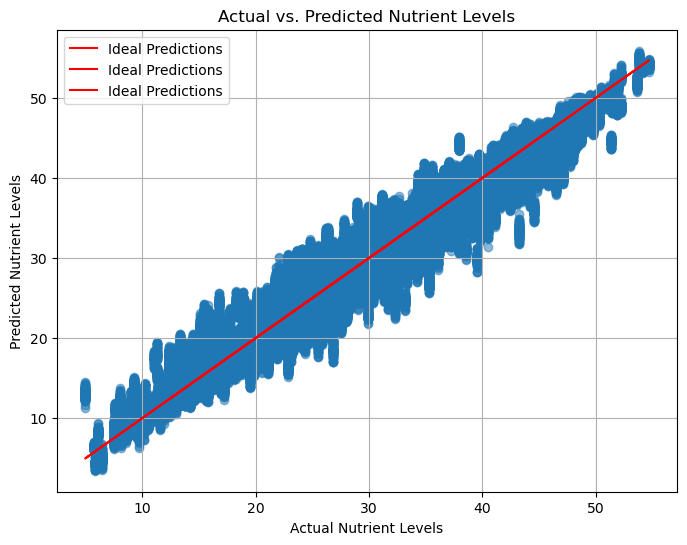

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot(y_test, y_test, color='red', label='Ideal Predictions')
plt.title('Actual vs. Predicted Nutrient Levels')
plt.xlabel('Actual Nutrient Levels')
plt.ylabel('Predicted Nutrient Levels')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
model.save('Rmodel.h5')  # Save the entire model